https://www.kaggle.com/kemical/kickstarter-projects
# Table of Content
- Imports
- Add Functions
- Load Data
- Dataset Overview
- Summary of Dataset Overview Observations
- Visualization 
- Summary of Visualization Observations
- Cleaning
- Load Cleaned Data
- Feature Engineering/Extraction
- Checking Multicollinearity
- Checking Sampling
- Checking Normality
- Tools of the trade


..No matter how much you study, no matter how many classes you, No matter how far you go...... you'll alays be stupid....

# Imports

In [33]:
import cufflinks as cl
import datetime
from itertools import combinations 
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import neighbors

from scipy.stats import chi2_contingency
from scipy.stats import chi2

import scipy.stats as st

import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.api import het_breuschpagan

import seaborn as sns

from yellowbrick.regressor import CooksDistance
import warnings
warnings.filterwarnings('ignore')


from laurentstar import Cleaner #My Modules
from laurentstar import ColorFormatting
%matplotlib inline

# Add Functions

In [3]:
%run -i "scripts/functions.py"

# Load Data

In [2]:
file_path = os.path.join('data', 'ks-projects-201612.csv')
df = pd.read_csv(file_path, encoding="ISO-8859-1")

C:\Users\Laurent\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning:

Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.



# Dataset Overview

In [4]:
display(df.head())
display(df.info())
display(df.describe())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323750 entries, 0 to 323749
Data columns (total 17 columns):
ID                323750 non-null int64
name              323746 non-null object
category          323745 non-null object
main_category     323750 non-null object
currency          323750 non-null object
deadline          323750 non-null object
goal              323750 non-null object
launched          323750 non-null object
pledged           323750 non-null object
state             323750 non-null object
backers           323750 non-null object
country           323750 non-null object
usd pledged       319960 non-null object
Unnamed: 13       625 non-null object
Unnamed: 14       12 non-null object
Unnamed: 15       4 non-null object
Unnamed: 16       1 non-null float64
dtypes: float64(1), int64(1), object(15)
memory usage: 42.0+ MB


None

,ID,Unnamed: 16
count,3.237500e+05,1.0
mean,1.074943e+09,25.0
std,6.193352e+08,NaN
min,5.971000e+03,25.0
25%,5.375802e+08,25.0
50%,1.075818e+09,25.0
75%,1.611070e+09,25.0
max,2.147476e+09,25.0


In [5]:
print('Number of unique values for ID', df['ID '].nunique())
df.columns

Number of unique values for ID 323750


Index(['ID ', 'name ', 'category ', 'main_category ', 'currency ', 'deadline ',
       'goal ', 'launched ', 'pledged ', 'state ', 'backers ', 'country ',
       'usd pledged ', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16'],
      dtype='object')

### <span style="color:blue">Observations</span>
    
    - Unnamed: 13, 14, 15, 16 are all blank when opened with Notepad++ and Microsoft Excel. The 2018 version of the dataset
      has 3 additional columns representing a country and how much it pledged. These columns may have been 
      accidentally picked up using ISO-8859-1 encoding when loading the data
    - Based on the values observation the goal should be a numeric column but the actual values are of different currency.
    - The ID has a unique value for every row. Since it is identification this is expected and it is not useful for   
      analysis. 
    - All column names have white space at the end.

In [81]:
display(df[df['backers '].str.isnumeric() == False][['backers ', 'state ', 'pledged ', 'launched ']].head())

print("Number of observation that aren't numeric:", df[df['backers '].str.isnumeric() == False]['backers '].count())

print("Number of unique observations that aren't numeric:", 
      df[df['backers '].str.isnumeric() == False]['backers '].nunique(), '\n')

print("Unique Observations that aren't numeric:\n", 
      df[df['backers '].str.isnumeric() == False]['backers '].unique())

,backers,state,pledged,launched
1454,failed,4262,2016-01-03 00:56:46,15000
1563,failed,3984,2014-08-09 03:16:02,13730
1794,failed,525,2011-11-21 23:25:46,5000
1931,failed,0,2014-08-21 19:56:10,6300
2420,successful,3035,2013-02-25 21:11:57,3000


Number of observation that aren't numeric: 624
Number of unique observations that aren't numeric: 9 

Unique Observations that aren't numeric:
 ['failed' 'successful' 'canceled' 'live' 'undefined' '2012-06-06 23:54:14'
 '2015-07-03 18:23:23' '2014-02-05 02:06:20' '88619.2']


### <span style="color:blue">Observations</span>
    - the majority of projects are funded by USA Dollars
    - There seems to be a mistake in the dataset. Whenever a backers string observation is not potentially numeric it has a 
      the status of the kickstarter which are the values of the "state " feature. Certain observations seems to be shifted 
      to the next column

In [11]:
print('Total number of projects:', df.shape[0])
print('Number of projects in 1970:', df[df['launched '].str.contains(pat = '1970-')]['launched '].count())
print('Number of projects in 2007:', df[df['launched '].str.contains(pat = '2007-')]['launched '].count())
print('Number of projects in 2008:', df[df['launched '].str.contains(pat = '2008-')]['launched '].count())
print('Number of projects in 2009:', df[df['launched '].str.contains(pat = '2009-')]['launched '].count())
print('Number of projects in 2010:', df[df['launched '].str.contains(pat = '2010-')]['launched '].count())
print('Number of projects in 2011:', df[df['launched '].str.contains(pat = '2011-')]['launched '].count())
print('Number of projects in 2012:', df[df['launched '].str.contains(pat = '2012-')]['launched '].count())
print('Number of projects in 2013:', df[df['launched '].str.contains(pat = '2013-')]['launched '].count())
print('Number of projects in 2014:', df[df['launched '].str.contains(pat = '2014-')]['launched '].count())
print('Number of projects in 2015:', df[df['launched '].str.contains(pat = '2015-')]['launched '].count())
print('Number of projects in 2016:', df[df['launched '].str.contains(pat = '2016-')]['launched '].count())


Total number of projects: 323750
Number of projects in 1970: 7
Number of projects in 2007: 0
Number of projects in 2008: 0
Number of projects in 2009: 1324
Number of projects in 2010: 10491
Number of projects in 2011: 26175
Number of projects in 2012: 41090
Number of projects in 2013: 44756
Number of projects in 2014: 67602
Number of projects in 2015: 77182
Number of projects in 2016: 54499


In [112]:
df[~df['Unnamed: 13'].isna()].head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
1454,1008705746,Zephyra´s new full length,'As The World Collapses',Metal,Music,SEK,2016-02-02 00:56:46,15000,2016-01-03 00:56:46,4262,failed,14,SE,504.94765278,NaN,NaN,NaN
1563,1009317190,French Cuisine,A Traditional Experience,Cookbooks,Food,USD,2014-09-08 00:46:23,13730,2014-08-09 03:16:02,3984,failed,46,US,3984,NaN,NaN,NaN
1794,1010871699,The Beginners Guide to being Unsuicidal,the one act,Theater,Theater,USD,2011-12-31 23:25:46,5000,2011-11-21 23:25:46,525,failed,10,US,525,NaN,NaN,NaN
1931,1011687764,Best OnLine Classifieds,Ever / No More Spam,Web,Technology,USD,2014-09-20 19:56:10,6300,2014-08-21 19:56:10,0,failed,0,US,0,NaN,NaN,NaN
2420,101453314,Social Media Ruined My Life,A Short Film from Adam S Curtis,Shorts,Film & Video,USD,2013-03-14 20:11:57,3000,2013-02-25 21:11:57,3035,successful,42,US,3035,NaN,NaN,NaN


### <span style="color:blue">Observations</span>
    - The number of kickerstarter projects increased yearly. Since kickstarter was founded in April 28, 2009 there 
      shouldn't be any recorded project below this year and thankfully there isn't. 
    - the "Unnamed" columns are finally starting to make sense. The data shifted over to other columns and because they 
      never had named they were given defualt names.
    - It seems ID was the only column uneffected by the data shifting
    - when ever the Unnamed: 13 is not null the data appears shifted. Could be an easy way to detect shifts
    - Some of the data was recorded wrong. The lanuch data of the project was recorded as 1970. 

In [81]:
display(df[df['state '].str.isnumeric() == True].head(5))
display(df[df['state '].str.isnumeric() == False]['state '].unique())
display(df['main_category '].unique())
display(df[df['currency '].str.len() > 3]['currency '].unique())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
1454,1008705746,Zephyra´s new full length,'As The World Collapses',Metal,Music,SEK,2016-02-02 00:56:46,15000,2016-01-03 00:56:46,4262,failed,14,SE,504.94765278,NaN,NaN,NaN
1563,1009317190,French Cuisine,A Traditional Experience,Cookbooks,Food,USD,2014-09-08 00:46:23,13730,2014-08-09 03:16:02,3984,failed,46,US,3984,NaN,NaN,NaN
1794,1010871699,The Beginners Guide to being Unsuicidal,the one act,Theater,Theater,USD,2011-12-31 23:25:46,5000,2011-11-21 23:25:46,525,failed,10,US,525,NaN,NaN,NaN
1931,1011687764,Best OnLine Classifieds,Ever / No More Spam,Web,Technology,USD,2014-09-20 19:56:10,6300,2014-08-21 19:56:10,0,failed,0,US,0,NaN,NaN,NaN
2420,101453314,Social Media Ruined My Life,A Short Film from Adam S Curtis,Shorts,Film & Video,USD,2013-03-14 20:11:57,3000,2013-02-25 21:11:57,3035,successful,42,US,3035,NaN,NaN,NaN


array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended', '4488.01', '14309.36', '2011-06-04 01:17:48',
       '1800.5', '2016-06-28 21:36:59', '8609.6', '5600.65', '218.5',
       '10890.45', '3605.13', '2016-02-18 21:40:23', '9430.8', '9857.8',
       '1763.47', '11315.5', '218.75', '5656.43', '3285.11', '14032.77',
       '6983.18', '2016-02-22 21:57:30', '422.38', '130.16', '157323.21',
       '5275.01', '9210.69', '33.06', '1327.89', '1111.11', '5425.64',
       '25651.99', '6972.6', '7000.58', '3065.7', '2015-09-08 22:08:39',
       '2571.31', '63.01', '2013-01-03 03:45:14', '140.01',
       '2015-10-10 01:00:00', '2015-01-28 13:53:56', '35.01', '7253.01',
       '109301.56', '28751.5', '2016-02-15 17:24:27', '111307.22',
       '7326.46', '7281.1'], dtype=object)

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism', 'Metal', 'Cookbooks', 'Web',
       'Shorts', 'Plays', 'Hardware', 'Playing Cards', 'World Music',
       'Mobile Games', 'Camera Equipment', 'Classical Music',
       'Conceptual Art', 'Nonfiction', 'Product Design', 'Documentary',
       'Video Games', ' 50 Years in the Making', 'Country & Folk',
       'Mixed Media', 'Comic Books', ' Retro Gaming art.', 'Places',
       'Events', 'Fiction', 'Tabletop Games', 'Video', 'Performance Art',
       'Small Batch', "Children's Books", 'Poetry', 'Public Art',
       'Art Books', 'Drama', 'Apparel', 'Sculpture', 'DIY', 'Hip-Hop',
       'Accessories', 'People', 'Webseries', 'Interactive Design',
       'Periodicals', 'Vegan', 'Indie Rock', 'Academic', 'Pop',
       ' M.ercury E.dition)', 'Faith', 'Jazz', 'Space Exploration',
       'Performances', 'Digital A

array(['Music', 'Food', 'Theater', 'Technology', 'Film & Video', 'Games',
       'Publishing', 'Design', 'Rock', 'Comics', 'Crafts', 'Photography',
       'Journalism', 'Fashion', 'Software', 'Dance', ' Be active!',
       'Nonfiction', ' clothing company', 'Painting',
       ' tango and culture', ' Religion ', 'Apparel'], dtype=object)

### <span style="color:blue">Observations</span>
https://www.kickstarter.com/projects/1871325530/french-cuisine-a-traditional-experience/comments   
    
    - Based on this url that leads to observation identified as number 1563, It seems the scraping process is incorrect. It 
      has "French Cruisine" as the name of the project but the full name is "French Cuisine; A Traditional Experience" 
      with the second half of the title put as the catagory. Its catagory should really be "Cookbooks" This shows why the 
      data has been shifted. 
https://www.kickstarter.com/projects/1871325530/french-cuisine-a-traditional-experience/description

    - This page leads to a list of catagories. There are 15 catagories 
|Catagories on the KickerStarter site| Catagories detected in the dataset|
|---|---|
|art|art|, 
|comics|comics|, 
|crafts|crafts|, 
|dance|dance|, 
|design|design|, 
|fashion|fashion|, 
|film & video|film & video|, 
|food|food|, 
|games|games|, 
|journalism|journalism|. 
|music|music|, 
|photography|photography|, 
|technology|technology|, 
|theater|theater|
|Publishing|Publishing|

      Each of the catagories can be clicked to 
      expand a list that shown additional catagories under them. 
      

In [43]:
df[df['deadline '].str.len() <= 4]['deadline '].unique()

array(['SEK', 'USD', 'GBP', 'CAD', 'SGD', 'EUR', 'AUD', 'NZD', 'Art'],
      dtype=object)

In [14]:
display(df[df['usd pledged '].str.isalpha() == True]['usd pledged '].unique())
display(df[df['country '].str.isalpha() == True]['country '].unique())

array(['SE', 'US', 'GB', 'CA', 'SG', 'FR', 'AU', 'NL', 'IE', 'DE',
       'successful', 'failed', 'NZ', 'ES', 'IT'], dtype=object)

array(['GB', 'US', 'CA', 'NO', 'AU', 'IT', 'DE', 'IE', 'ES', 'MX', 'SE',
       'FR', 'NL', 'NZ', 'CH', 'AT', 'BE', 'DK', 'HK', 'LU', 'SG',
       'failed', 'successful'], dtype=object)

### <span style="color:blue">Observations</span>

https://www.kickstarter.com/discover/advanced?raised=1&ref=discovery_overlay&sort=end_date&staff_picks=1
    
    - This link goes to the staff pick of 75% nearly funded projects. At the bottom users can change what the currency they
      see is. There are 14 currency with identification names of 3 uppercase letters. There is no currency that doesn't 
      follow this format 

https://www.kickstarter.com/discover/advanced?raised=1&ref=discovery_overlay&sort=end_date&staff_picks=1
    
    - Every currency in this dataset is an option on kaggle but kaggle has additional options

==========================================================================================================================
    
    - Every country recorded only uses its abbrivated 2 letter name and there doesn't appear to be any exceptions.
 

# Summary of Dataset Overview Observations

   1. Unnamed: 13, 14, 15, 16 are all blank when opened with Notepad++ and Microsoft Excel. The 2018 version of the dataset
      has 3 additional columns representing a country and how much it pledged. These columns may have been accidentally 
      picked up using ISO-8859-1 encoding when loading the data
    
   2. Based on the values observation the goal should be a numeric column but the actual values are of different currency.
    
   3. All column names have white space at the end.
   
   4. the majority of projects are funded by USA Dollars
    
   5. There seems to be a mistake in the dataset. Whenever a backers string observation is not potentially numeric it has a 
      the status of the kickstarter which are the values of the "state " feature. Certain observations seems to be shifted 
      to the next column
    
   6. The number of kickerstarter projects increased yearly. Since kickstarter was founded in April 28, 2009 there 
      shouldn't be any recorded project below this year and thankfully there isn't. 
    
   7. the "Unnamed" columns are finally starting to make sense. The data shifted over to other columns and because they 
      never had named they were given defualt names.
    
   8. 
      https://www.kickstarter.com/projects/1871325530/french-cuisine-a-traditional-experience/comments        
      Based on this url that leads to observation number 1563 it seems the scraping process is incorrect. It has "French
      Cruisine" as the name of the project but the full name is "French Cuisine; A Traditional Experience" with the second
      half of the title put as the catagory. Its catagory should really be "Cookbooks" This shows why the data has been   
      shifted. 
      
   9. 
      https://www.kickstarter.com/projects/1871325530/french-cuisine-a-traditional-experience/description                  
      This page leads to a list of catagories. There are 15 catagories (art, comics, crafts, dance, design, fashion, film & 
      video, food, games, journalism. music, photography, technology, Theater). Each of the catagories can be clicked to 
      expand a list that shown additional catagories under them. 
   
   
   10. 
      https://www.kickstarter.com/discover/advanced?raised=1&ref=discovery_overlay&sort=end_date&staff_picks=1
      This link goes to the staff pick of 75% nearly funded projects. At the bottom users can change what the currency they
      see is. There are 14 currency with identification names of 3 uppercase letters. There is no currency that doesn't 
      follow this format.
   
   11.   
      https://www.kickstarter.com/discover/advanced?raised=1&ref=discovery_overlay&sort=end_date&staff_picks=1
      Every currency in this dataset is an option on kaggle but kaggle has additional options
   
   12. Every country recorded only uses it Abbrivated name and there doesn't appear to be any exceptions.

In [ ]:
prob = 0.95
alpha = 1.0 - prob
for col in list(combinations(['category', 'main_category', 'currency', 'goal', 'country'], 2)):
    stat, p, dof, expected =  chi2_contingency(pd.crosstab(clean_df[col[0]],  clean_df[col[1]]))
    critical = chi2.ppf(prob, dof)
    
    print(f'{ColorFormatting.BOLD}{col[0]} {col[1]}{ColorFormatting.END}')
    print(f'Chi Statistic: {stat}, P-value: {p}, Degree of Freedom: {dof}')    
    print('Dependent (reject H0)') if p <= alpha else print('Independent (fail to reject H0)')
    print()

### <span style="color:orange">Observations & Assumptions </span>

- None of the by 2 combinations passed the test for independenc.
- This test checks if the variables are independent but not how indepenedent they are.

# Visualization

Number of unique categories: 770
Number of categories in top 10 percent: 77


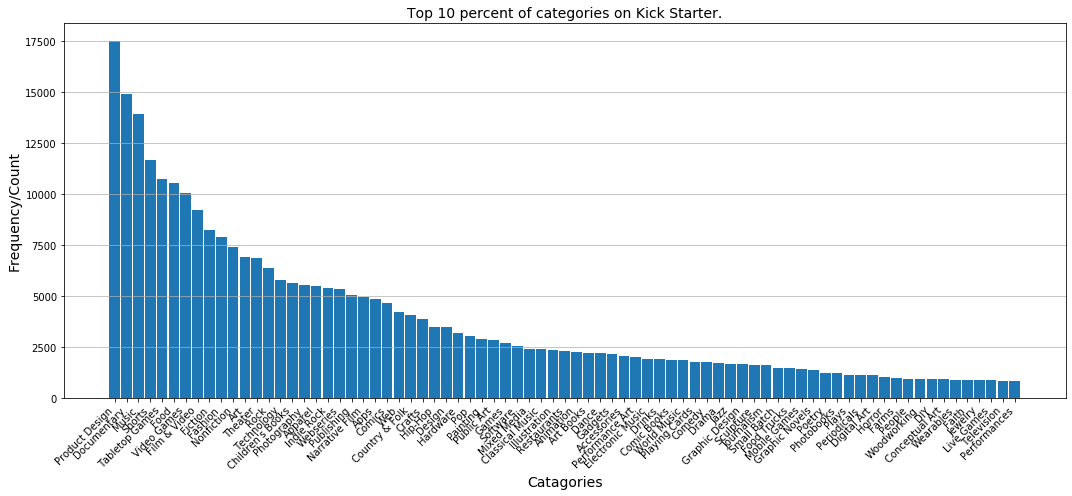

In [24]:
#Declaration
fig, ax = plt.subplots(nrows=1, figsize=(15,7))
length = df['category '].value_counts().size
percent = 10/100


print("Number of unique categories:", df['category '].nunique())
print("Number of categories in top 10 percent:", int(length*percent))

x = df['category '].value_counts().index[:int(length*percent)]
y = df['category '].value_counts()[:int(length*percent)]
ax.set_title("Top 10 percent of categories on Kick Starter.", fontsize=14)
ax.set_xlabel("Catagories", fontsize=14)
ax.set_ylabel("Frequency/Count", fontsize=14)
ax.bar(x=x, height=y, width=0.9)
ax.yaxis.grid(linestyle='-', linewidth=0.7)
ax.set_xticklabels(x, rotation=45, ha='right')

plt.tight_layout();

Number of unique main categories: 120


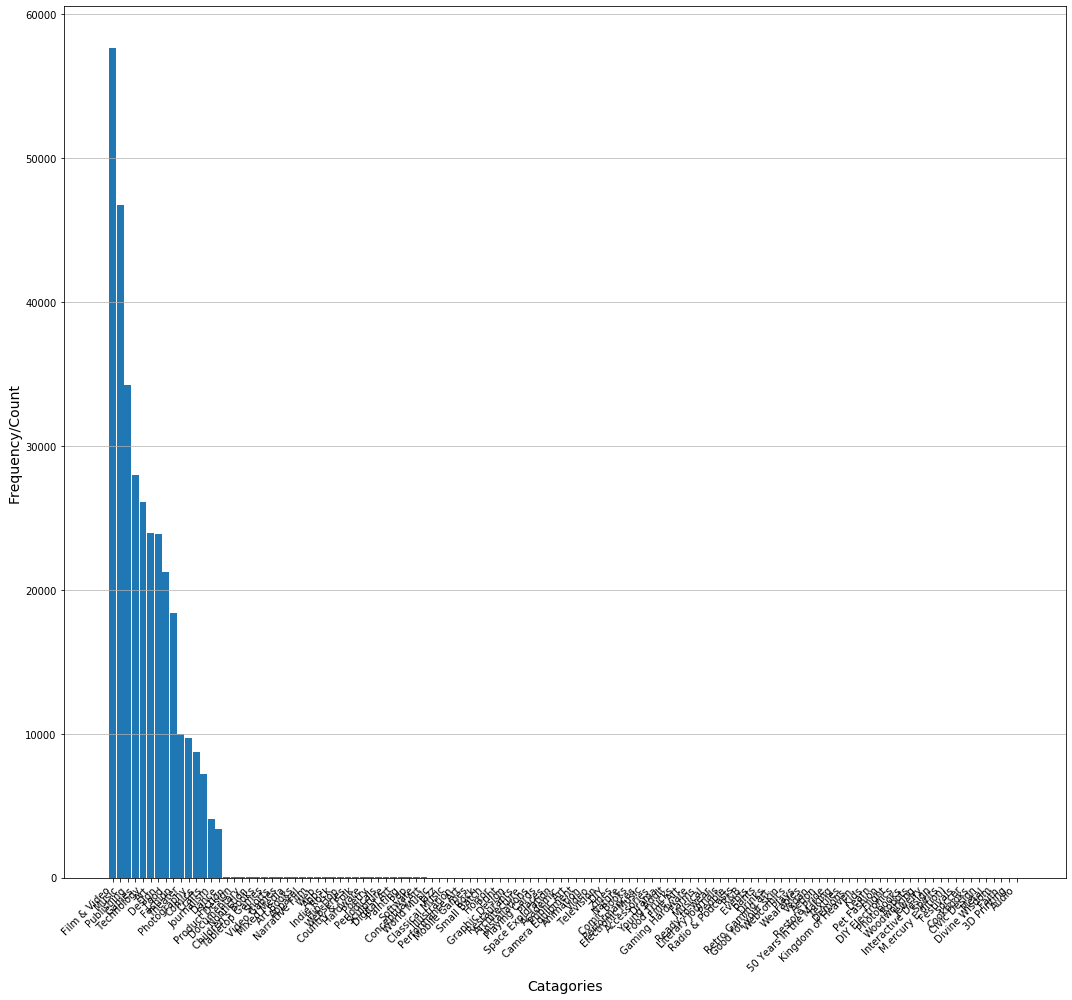

In [28]:
#Declaration
fig, ax = plt.subplots(nrows=1, figsize=(15,14))
x = df['main_category '].value_counts().index


print("Number of unique main categories:", df['main_category '].nunique())

y = df['main_category '].value_counts()
ax.set_xlabel("Catagories", fontsize=14)
ax.set_ylabel("Frequency/Count", fontsize=14)
ax.bar(x=x, height=y, width=0.9)
ax.yaxis.grid(linestyle='-', linewidth=0.7)
ax.set_xticklabels(x, rotation=45, ha='right')

plt.tight_layout();

### <span style="color:blue">Observations</span>
    - the majority of catagories were not recorded to generalize. Instead they appear to represent very specific 
      products/ideas/events only appearing 1 time in the entire dataset.
    - Main catagory has 120 unique values. This is ~ 1/7 of the "catagory " unique values. This may be a better 
      representation of what the kick starter project catagorizes as.

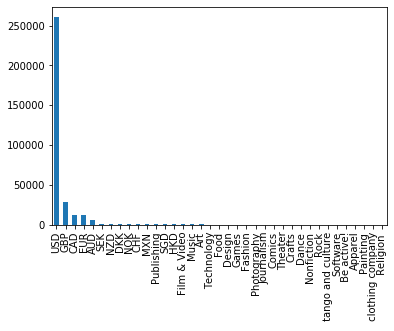

In [84]:
df['currency '].value_counts().plot('bar');

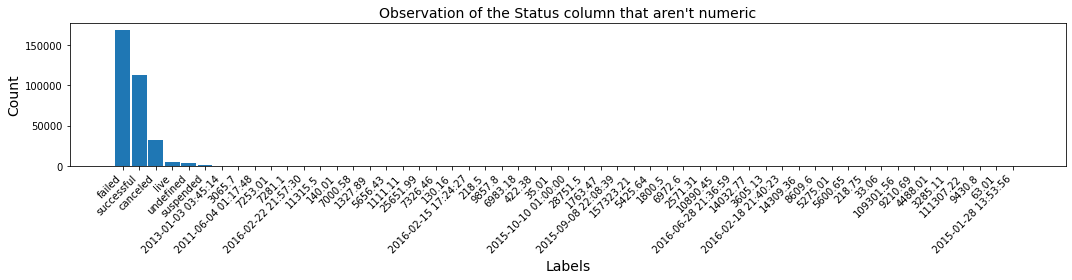

In [113]:
fig, ax = plt.subplots(figsize=(15,4))
x = df[df['state '].str.isnumeric() == False]['state '].value_counts().index
y = df[df['state '].str.isnumeric() == False]['state '].value_counts()

ax.bar(x=x, height=y, width=0.9)
ax.set_xticklabels(x, rotation=45, ha='right')
ax.set_title("Observation of the Status column that aren't numeric", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel("Labels", fontsize=14)
plt.tight_layout();

### <span style="color:blue">Observations</span>
    - It seems the shifting of data is with multiple columns as there are few unique dates and currency are apart of the 
    "state " column.


# Summary of Visualization Observations

   1. It seems the shifting of data is within multiple columns as there are a few unique dates and currencies apart of the  "state " column.
   2. the majority of catagories were not recorded to generalize. Instead they appear to represent very specific 
      products/ideas/events only appearing 1 time in the entire dataset.
   3. "main catagory " column has 120 unique values. This is ~ 1/7 of the "catagory " unique values. This may be a better 
      representation of what the kick starter project catagorizes as.

# Cleaning

In [3]:
clean_df = df.copy()

# 'ID ' was the only column uneffected by the data shifting but it not very useful for analysis
clean_df.drop(columns=['ID '], axis=1, inplace=True)

# The column names have a weird whitespace at the end. Removing this. Using usd_pledged for readability.
clean_df.columns = [name.replace(' ', '') for name in clean_df.columns]
clean_df.rename(columns={'usdpledged': 'usd_pledged'}, inplace=True)

# Using my custom clean class methods built for cleaning this kickstarter dataset
clean = Cleaner()

# Apply the data shifting technique to all rows that are detected to have been shifted
clean_df = clean_df.fillna('').apply(lambda x: clean.shift_data_left(x), axis=1)

# Replace every row where the country was zero with a fixed version. Only fixes 7 rows
# '_' and 'tmp' are temporary variables I just like to use '_' first

_ = clean_df[clean_df['country'] == '0']['name'] + clean_df[clean_df['country'] == '0']['category']
tmp = clean_df[clean_df['country'] == '0'].shift(-1, axis = 1)

tmp['name'] = _
tmp['country'] = 'N'
tmp['usd_pledged'] = 0
tmp['Unnamed:16'] = ''

clean_df.loc[clean_df.index.isin(tmp.index)] = tmp

# Replace every row where the country was N,"0 with a fixed version. fixes 3790 rows
_ = clean_df[clean_df['country'] == 'N,"0']
_['country'] = 'N'
_['usd_pledged'] = 0
clean_df.loc[clean_df.index.isin(_.index)] = _


clean_df.replace('', np.nan, inplace=True)
clean_df.drop(columns=['Unnamed:13', 'Unnamed:14', 'Unnamed:15', 'Unnamed:16'], inplace=True)
clean_df.dropna(inplace=True)

clean_df.to_csv('data/kickstarter_2016_clean.csv', encoding='utf-8', index=False)

# Load Cleaned Data

In [4]:
file_path = os.path.join('data', 'kickstarter_2016_clean.csv')
clean_df = pd.read_csv(file_path)

# Feature Engineering/Extraction

In [5]:
clean_df['deadline'] = clean_df['deadline'].astype('datetime64[ns]') 
clean_df['launched'] = clean_df['launched'].astype('datetime64[ns]') 

#Makes it easier to analysis by year
clean_df['launch_year'] =  clean_df['launched'].map(lambda x: x.year)

#launch year 1970 observation. Salt of the Earth: A Dead Sea Movie (Canceled)
clean_df.iloc[2443]["launched"] = clean_df.iloc[2443]["launched"].replace(year=2010, month=7, day=23) 

#Could not confirm the rest of the launch year 1970 observations. Need to drop them.
clean_df.drop(clean_df[clean_df["launch_year"] < 2009].index, inplace=True)

# <span style="color:red">Boot Strap Estimates: Sampling Assumption  </span>

In [6]:
boot = None
mean = {'goal' : [],
         'pledged' : [],
         'backers' : [],
         'usd_pledged' : [],
         'launch_year' : [],
        }
       

var = {'goal' : [],
         'pledged' : [],
         'backers' : [],
         'usd_pledged' : [],
         'launch_year' : [],
        }
       

std = {'goal' : [],
         'pledged' : [],
         'backers' : [],
         'usd_pledged' : [],
         'launch_year' : [],
        }
       

median = {'goal' : [],
         'pledged' : [],
         'backers' : [],
         'usd_pledged' : [],
         'launch_year' : [],
        }

proportion =[]


for i in range(1000):   
    
    if i % 100 == 0:
        print(datetime.datetime.now())
    
    boot = resample(clean_df, replace=True, n_samples=clean_df.shape[0])

    proportion.append([list(boot.main_category.value_counts(normalize=True).sort_index().index),
                       list(boot.main_category.value_counts(normalize=True).sort_index().values),
                       list(boot.main_category.value_counts().sort_index().values)
                      ])
    
    std['goal'].append(boot.goal.std())
    std['pledged'].append(boot.pledged.std())
    std['backers'].append(boot.backers.std())
    std['usd_pledged'].append(boot.usd_pledged.std())
    std['launch_year'].append(boot.launch_year.std())
              
    var['goal'].append(boot.goal.var())
    var['pledged'].append(boot.pledged.var())
    var['backers'].append(boot.backers.var())
    var['usd_pledged'].append(boot.usd_pledged.var())
    var['launch_year'].append(boot.launch_year.var())
    
    mean['goal'].append(boot.goal.mean())
    mean['pledged'].append(boot.pledged.mean())
    mean['backers'].append(boot.backers.mean())
    mean['usd_pledged'].append(boot.usd_pledged.mean())
    mean['launch_year'].append(boot.launch_year.mean())
    
    median['goal'].append(boot.goal.median())
    median['pledged'].append(boot.pledged.median())
    median['backers'].append(boot.backers.median())
    median['usd_pledged'].append(boot.usd_pledged.median())
    median['launch_year'].append(boot.launch_year.median()) 

2020-07-23 13:26:04.380965
2020-07-23 13:29:01.519331
2020-07-23 13:31:30.051052
2020-07-23 13:34:29.025585
2020-07-23 13:37:24.110618
2020-07-23 13:40:11.452116
2020-07-23 13:42:54.831113
2020-07-23 13:45:40.563146
2020-07-23 13:48:23.313112
2020-07-23 13:51:08.471111


In [7]:
std['goal'] = np.array(std['goal'])
std['pledged'] = np.array(std['pledged'])
std['backers'] = np.array(std['backers'])
std['usd_pledged'] = np.array(std['usd_pledged'])
std['launch_year'] = np.array(std['launch_year'])

var['goal'] = np.array(var['goal'])
var['pledged'] = np.array(var['pledged'])
var['backers'] = np.array(var['backers'])
var['usd_pledged'] = np.array(var['usd_pledged'])
var['launch_year'] = np.array(var['launch_year'])

mean['goal'] = np.array(mean['goal'])
mean['pledged'] = np.array(mean['pledged'])
mean['backers'] = np.array(mean['backers'])
mean['usd_pledged'] = np.array(mean['usd_pledged'])
mean['launch_year'] = np.array(mean['launch_year'])

median['goal'] = np.array(median['goal'])
median['pledged'] = np.array(median['pledged'])
median['backers'] = np.array(median['backers'])
median['usd_pledged'] = np.array(median['usd_pledged'])
median['launch_year'] = np.array(median['launch_year'])

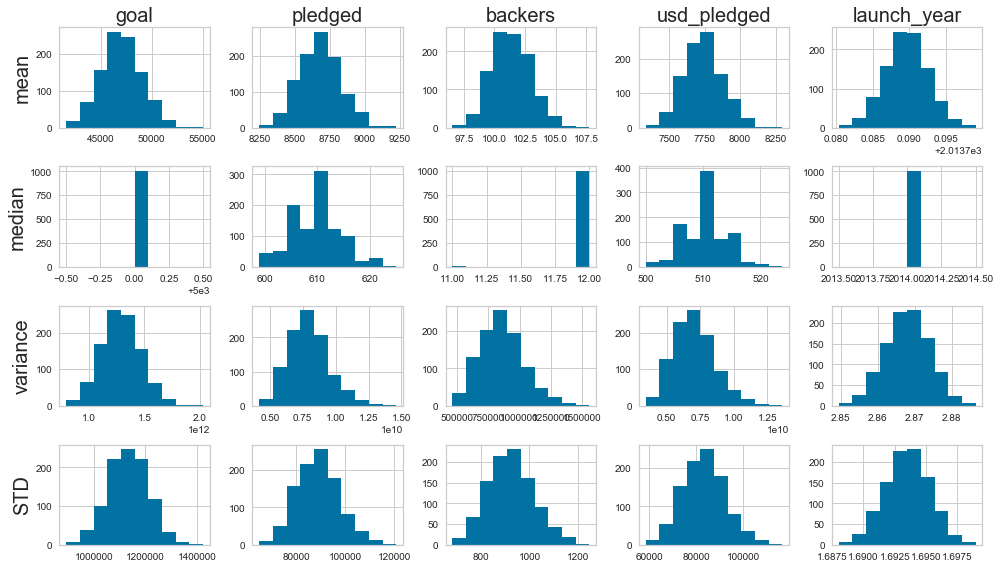

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(14, 8))
_ = ['goal', 'pledged', 'backers', 'usd_pledged', 'launch_year']
ax[0][0].set_title(_[0],fontsize=20 )
ax[0][1].set_title(_[1],fontsize=20 )
ax[0][2].set_title(_[2],fontsize=20 )
ax[0][3].set_title(_[3],fontsize=20 )
ax[0][4].set_title(_[4],fontsize=20 )
ax[0][0].set_ylabel("mean", fontsize=20)
ax[1][0].set_ylabel("median", fontsize=20)
ax[2][0].set_ylabel("variance", fontsize=20)
ax[3][0].set_ylabel("STD", fontsize=20)
for index, col in enumerate(_):
    ax[0][index].hist(mean[col])
    ax[1][index].hist(median[col])
    ax[2][index].hist(var[col])
    ax[3][index].hist(std[col])
    plt.tight_layout();

In [9]:
display(ci_and_point_estimate(mean, 'mean'))
display(ci_and_point_estimate(median, 'median'))
display(ci_and_point_estimate(var, 'variance'))
display(ci_and_point_estimate(std, 'standard-deviation'))

{'statistic_name': 'mean',
 'goal': [(47034.64046099421, 47042.53908702517),
  47038.58977400969,
  63.71966230186872],
 'pledged': [(8680.667157093527, 8681.257342074625),
  8680.962249584076,
  4.761130295785026],
 'backers': [(101.37073711582127, 101.37701255289335),
  101.37387483435731,
  0.05062509979108566],
 'usd_pledged': [(7739.260771039503, 7739.810511788451),
  7739.535641413977,
  4.434859270352893],
 'launch_year': [(2013.7895656655314, 2013.7895771686653),
  2013.7895714170984,
  9.27978872072911e-05]}

{'statistic_name': 'median',
 'goal': [(5000.0, 5000.0), 5000.0, 0.0],
 'pledged': [(609.4489093862974, 609.4663306137027),
  609.45762,
  0.1405402310215833],
 'backers': [(11.995876289159968, 11.996123710840033),
  11.996,
  0.001995995991979944],
 'usd_pledged': [(510.12832009909187, 510.1424385940019),
  510.13537934654687,
  0.1138964833059804],
 'launch_year': [(2014.0, 2014.0), 2014.0, 0.0]}

{'statistic_name': 'variance',
 'goal': [(1288581452045.1394, 1289283591858.0212),
  1288932521951.5803,
  5664290420.908021],
 'pledged': [(7965097801.963667, 7971222607.1071415),
  7968160204.535404,
  49409924.44471065],
 'backers': [(861010.3509021387, 861708.1626736426),
  861359.2567878907,
  5629.375318717854],
 'usd_pledged': [(7023120922.162103, 7029186294.904159),
  7026153608.533131,
  48930472.38134827],
 'launch_year': [(2.8680179687032785, 2.868041704199359),
  2.868029836451319,
  0.00019147859246632662]}

{'statistic_name': 'standard-deviation',
 'goal': [(1132408.7299869019, 1132718.1940005184),
  1132563.4619937101,
  2496.502855676864],
 'pledged': [(88825.34592620512, 88859.33838012682),
  88842.34215316597,
  274.223349252383],
 'backers': [(923.0536306161403, 923.4252633624735),
  923.2394469893069,
  2.998029404587216],
 'usd_pledged': [(83304.10992336625, 83339.94950828681),
  83322.02971582653,
  289.1244931998176],
 'launch_year': [(1.6935214118525659, 1.6935284197190543),
  1.69352491578581,
  5.6533741987506256e-05]}

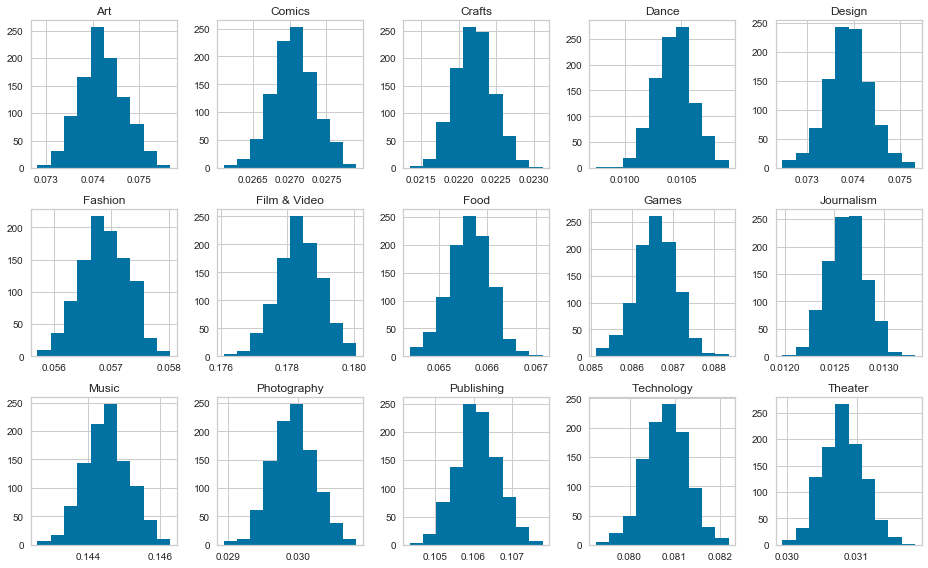

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(13, 8))

_ = proportion_data_formatting(proportion)
for index, key  in enumerate(list(_.keys())):
    ax[int(index/5)][int(index%5)].set_title(key)
    ax[int(index/5)][int(index%5)].hist(_[key])
plt.tight_layout()

In [11]:
_ = proportion_data_formatting(proportion)
estimate = ci_and_point_estimate(_, 'class_proportions')

for i in list(estimate.keys())[1:]:
    print(f'{i}\nConfidence_interval: {estimate[i][0]} \nProportion_Estimate: {estimate[i][1]}\n')
sum([estimate[i][1] for i in estimate][1:])

Art
Confidence_interval: (0.07419920992815703, 0.07420105695349764) 
Proportion_Estimate: 0.07420013344082733

Comics
Confidence_interval: (0.027053717005052193, 0.027054833401293665) 
Proportion_Estimate: 0.02705427520317293

Crafts
Confidence_interval: (0.02220539893282417, 0.022206414287084458) 
Proportion_Estimate: 0.022205906609954314

Dance
Confidence_interval: (0.010433063043504054, 0.010433740152897986) 
Proportion_Estimate: 0.01043340159820102

Design
Confidence_interval: (0.07388703666018075, 0.07388886923932471) 
Proportion_Estimate: 0.07388795294975273

Fashion
Confidence_interval: (0.05687465636701264, 0.056876254088632186) 
Proportion_Estimate: 0.05687545522782241

Film & Video
Confidence_interval: (0.1783609460819532, 0.17836355112104063) 
Proportion_Estimate: 0.1783622486014969

Food
Confidence_interval: (0.0656295203458527, 0.06563119275945742) 
Proportion_Estimate: 0.06563035655265506

Games
Confidence_interval: (0.08657488139125497, 0.08657683032713548) 
Proportion_E

1.0

In [12]:
sample_estimate = {'Film & Video' : 74810, 
                   'Music' : 62595,
                   'Games' : 53179, 
                   'Publishing' : 50307, 
                   'Technology' : 43069, 
                   'Design' : 41598, 
                   'Art' : 39416, 
                   'Fashion' : 31897, 
                   'Food' : 30142, 
                   'Comics' : 16319,
                   'Photography' : 12461,
                   'Theater' : 12287, 
                   'Crafts' : 11509, 
                   'Journalism' : 5768, 
                   'Dance' : 4265 
                  }

sample_estimate = {key: [value, value/sum(sample_estimate.values())] for key, value in sample_estimate.items()}

sample = proportion_data_formatting(proportion)

"""
Ho: µ = x_bar  ("the sample mean is equal to the [proposed] population mean")
Ha: µ ≠ x_bar  ("the sample mean is not equal to the [proposed] population mean")
"""

for i in sample_estimate:
    mu = estimate[i][1]            # Estimated Population mean(MEW)
    x_bar = sample_estimate[i][1]  # sample mean
    std_error = estimate[i][2]     # Standard error (sigma/sqrt(n))
    
    n = len(sample[i])

    # Degrees of Freedom
    dof = n-1
    
    numerator = x_bar - mu
    denominator = std_error
    
    t = numerator/denominator
    t_crit = st.t.ppf(1 - 0.05, df=dof)
    
    results = st.ttest_1samp(a=sample[i], popmean=mu) 
    
    if (results[0]>t_crit) and (results[1]<0.05):
        print ("Null hypothesis rejected. Results are statistically significant with t-value =", 
           round(results[0], 2), "and p-value =", np.round((results[1]), 4))
    else:
        print(f""" Results are not statistically significant.
    fail to reject Ho
        Class: {i}
        Sample Mean: {x_bar}
        Population Mean: {mu}
        Standard Error: {std_error}
        t-value: {results[0]}
        p-value: {results[1]}
        """)

 Results are not statistically significant.
    fail to reject Ho
        Class: Film & Video
        Sample Mean: 0.1527913369905764
        Population Mean: 0.1783622486014969
        Standard Error: 2.1015327258546117e-05
        t-value: 0.0
        p-value: 1.0
        
 Results are not statistically significant.
    fail to reject Ho
        Class: Music
        Sample Mean: 0.12784352010326333
        Population Mean: 0.14450732534541713
        Standard Error: 1.959291456517401e-05
        t-value: 0.0
        p-value: 1.0
        
 Results are not statistically significant.
    fail to reject Ho
        Class: Games
        Sample Mean: 0.10861235810482373
        Population Mean: 0.08657585585919522
        Standard Error: 1.5722422566584767e-05
        t-value: 0.0
        p-value: 1.0
        
 Results are not statistically significant.
    fail to reject Ho
        Class: Publishing
        Sample Mean: 0.10274660860827332
        Population Mean: 0.10609828287602051
     

In [13]:
sample_estimate = clean_df.main_category.value_counts(normalize=True)
for i in sample_estimate.index:
    print(i)
    mu = estimate[i][1]         # Estimated Population mean(MEW)
    x_bar = sample_estimate[i]  # sample mean
    std_error = estimate[i][2]  # Standard error (sigma/sqrt(n))
    
    n = len(sample[i])

    # Degrees of Freedom
    dof = n-1
    
    numerator = x_bar - mu
    denominator = std_error
    
    t = numerator/denominator
    t_crit = st.t.ppf(1 - 0.05, df=dof)
    
    results = st.ttest_1samp(a=sample[i], popmean=mu) 
    
    if (results[0]>t_crit) and (results[1]<0.05):
        print ("Null hypothesis rejected. Results are statistically significant with t-value =", 
           round(results[0], 2), "and p-value =", np.round((results[1]), 4))
    else:
        print(f""" Results are not statistically significant.
    fail to reject Ho
        Class: {i}
        Sample Mean: {x_bar}
        Population Mean: {mu}
        Standard Error: {std_error}
        t-value: {results[0]}
        p-value: {results[1]}
        """)

Film & Video
 Results are not statistically significant.
    fail to reject Ho
        Class: Film & Video
        Sample Mean: 0.17836281696057626
        Population Mean: 0.1783622486014969
        Standard Error: 2.1015327258546117e-05
        t-value: 0.0
        p-value: 1.0
        
Music
 Results are not statistically significant.
    fail to reject Ho
        Class: Music
        Sample Mean: 0.14453309610519585
        Population Mean: 0.14450732534541713
        Standard Error: 1.959291456517401e-05
        t-value: 0.0
        p-value: 1.0
        
Publishing
 Results are not statistically significant.
    fail to reject Ho
        Class: Publishing
        Sample Mean: 0.10608854663787805
        Population Mean: 0.10609828287602051
        Standard Error: 1.737220690167015e-05
        t-value: 0.0
        p-value: 1.0
        
Games
 Results are not statistically significant.
    fail to reject Ho
        Class: Games
        Sample Mean: 0.0866129814449294
        Populat

# <span style="color:red"> Multicollinearity Assumption</span>

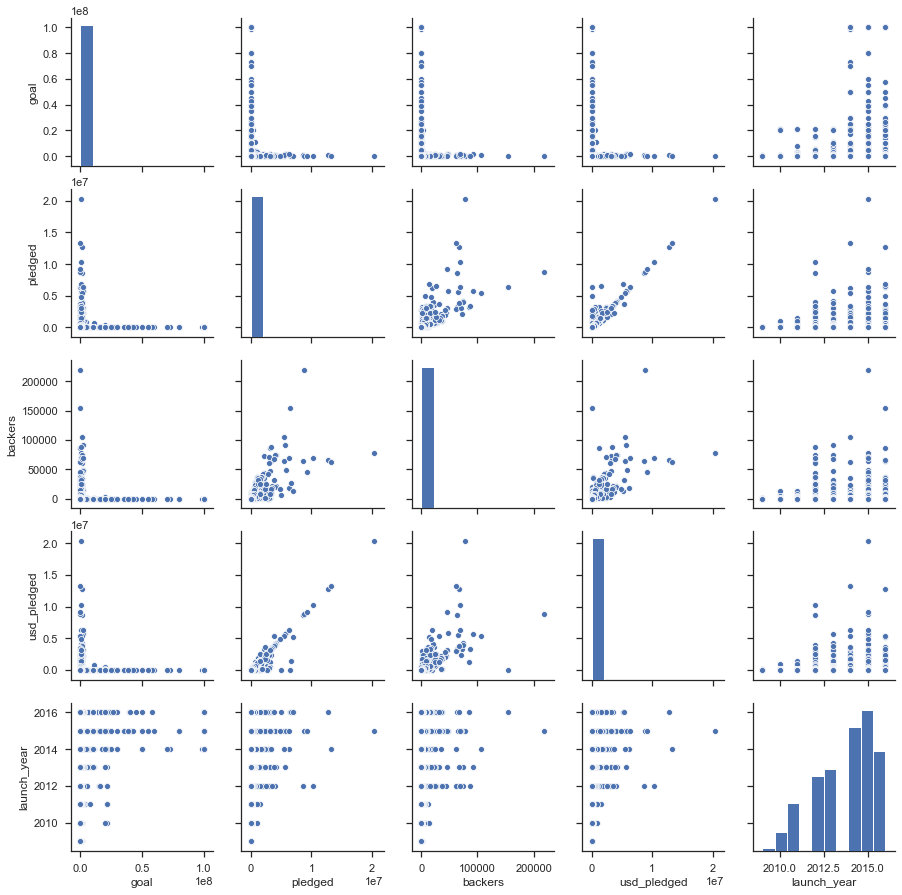

In [14]:
sns.set(style="ticks")
sns.pairplot(clean_df);

### <span style="color:orange">Observations & Assumptions </span>
- Pledged and usd_pledged seems to be linearly corralated but that doesn't matter. It was confirmed earlier most of the project were funded with US dollars.
- Wow this graph is implying lower goals get more pledged money.
- "Goal" looks very strange. It takes an L shape when plotted with every other feature. It also only has 7578 unique values in the whole dataset. This may just be people rounding to a common number 
- The data doesn't appear to be normally distrubtued OR there are such extreme values that it is hard to see

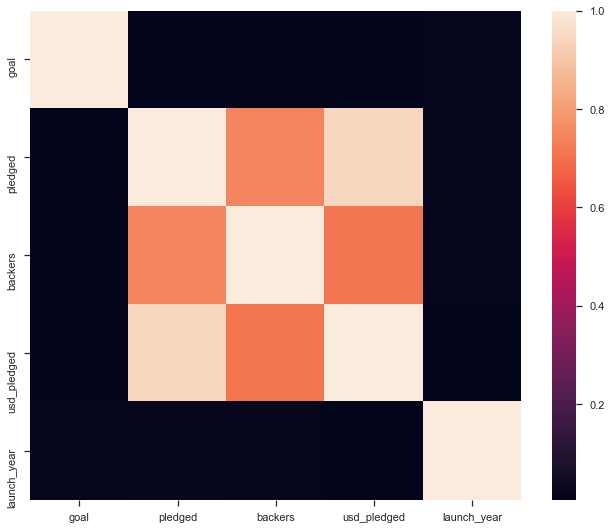

In [15]:
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(clean_df.corr());

### <span style="color:orange">Observations & Assumptions </span>
- Good, goals is completely independent!
- Backers and usd_pledge are highly corralated. Might need to get rid of one to avoid noise
- pledge and usd_pledge appear highly correlated. Maybe this will be useful for time series anaylsis but one of them needs to be removed

In [16]:
X = ['category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'country', 'launch_year', 'state', 
     'backers', 'usd_pledged']
y = "pledged"
_ = X
_.append(y)
encoded_df = mean_encoding(clean_df[_], X, y)
X = encoded_df.drop(columns = "pledged").assign(const=1)

pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

category          2.291176
main_category     2.320412
currency         16.565408
deadline          3.948977
goal              1.118550
launched         78.794548
country          16.576452
launch_year       1.031948
state             1.053905
backers          18.396894
usd_pledged      64.884618
const            22.409607
dtype: float64

# <span style="color:red"> Homoscedasticity Assumption </span>

In [31]:
X = ['category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'country', 'launch_year', 'state', 
     'backers', 'usd_pledged']
y = "pledged"
_ = X
_.append(y)
encoded_df = mean_encoding(clean_df[_], X, y)

X = encoded_df.drop(columns = "pledged").assign(const=1)
y = encoded_df['pledged']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

knn = neighbors.KNeighborsRegressor(5)
y_bar = knn.fit(X_train, y_train).predict(X_test)

In [38]:
test = het_breuschpagan(y_bar, X_test)
test

(60687.07846446772, 0.0, 22049.31342958308, 0.0)

In [22]:
# visualizer = CooksDistance()

# X = clean_df.drop(columns = ['pledged', 'state', 'backers', 'usd_pledged'])
# for y in ['pledged', 'state', 'backers', 'usd_pledged']:
#     visualizer.fit(X, y)

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,launch_year
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000.0,2015-08-11 12:12:28,0.0,failed,0.0,GB,0.0,2015
1,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000.0,2013-01-12 00:20:50,220.0,failed,3.0,US,220.0,2013
2,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.0,failed,1.0,US,1.0,2012
3,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500.0,2015-07-04 08:35:03,1283.0,canceled,14.0,US,1283.0,2015
4,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000.0,2016-02-26 13:38:27,52375.0,successful,224.0,US,52375.0,2016


### <span style="color:orange">Observations & Assumptions </span>

- The KickStart Statistics pages is automatically updated once a day. I recorded frequecy of project catagories and success rate to the  date 6/19/2020. 
- The first year of KickStarter 2009 didn't have obesevations for all main categories. It is missing one
- Chi square test Goodness of Fit
   
  **The assumptions of the Chi-square Test of Independents:**
    1. <span style="color:green"> The data in the cells should be frequencies, or counts of cases rather than percentages or some other transformation of the data. </span>

    2. <span style="color:green"> Expected value should be greater than 3 </span>

    3. <span style="color:green"> Observation must be independent </span>
    
  H0 :  there is no relation between the variables
  H1 :  there is a relation between the variables
  

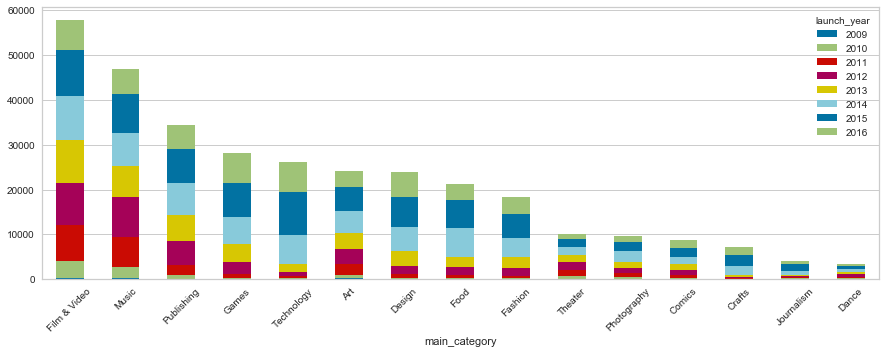

In [13]:
df_plot = (clean_df.groupby(['launch_year', 'main_category']).size()
                                                            .reset_index()
                                                            .pivot(columns='launch_year', index='main_category', values=0))
df_plot['total'] = df_plot.sum(axis=1)
df_plot.sort_values('total', ascending=False, inplace=True)
df_plot[df_plot.columns[:-1]].plot(kind='bar', stacked=True, rot=45, figsize=(15,5))
plt.grid(axis='x');

### <span style="color:orange">Observations & Assumptions </span>
- Proportion of the categories seems to remain consistent dispite rising number of projects for all categories.

# <span style="color:red"> Checking Normality </span>

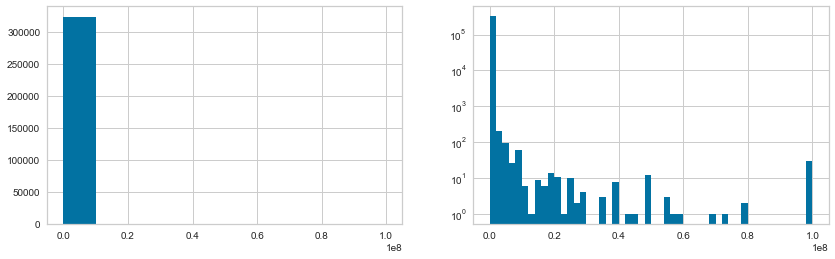

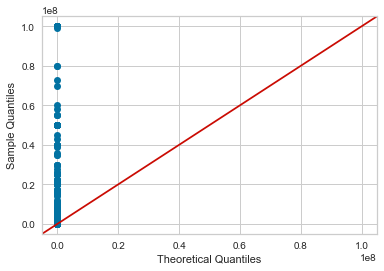

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))

ax[0].hist(clean_df.goal)
ax[1].hist(clean_df.goal, log=True, bins=50)

sm.qqplot(clean_df.goal, line ='45');

### <span style="color:orange">Observations & Assumptions </span>
- The only numeric predictor doesn't look like a normal distrubtion. It looks like a "pareto-distributed- meaning that most goals are small, some are medium, and a few are REALLY big". 
- I also plotted a qq plot since you really shouldn't be using histograms to check for normality. Unfortunately most of those points are not on the red line and this data is not normal

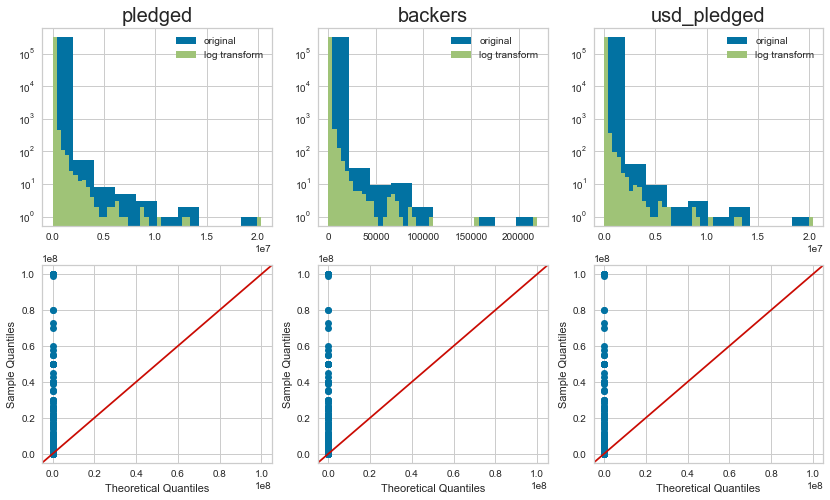

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))

for index, col in enumerate(['pledged','backers', 'usd_pledged']):
    ax[0][index].hist(clean_df[col], label='original')
    ax[0][index].hist(clean_df[col], log=True, bins=50, label='log transform')  
    ax[0][index].set_title(col,fontsize=20 )
    ax[0][index].legend(loc='upper right')
    sm.qqplot(clean_df.goal, ax=ax[1][index], line ='45');

### <span style="color:orange">Observations & Assumptions </span>
- The other numeric columns seems to follow the same pareto-distribution. 
- QQ-plots generated for all of them are similar. 
- This data is no good for a linear regression model. 

# The follwoing is to be remove and updated. Kept for future work

# Experiments To be removed

In [ ]:
# There is no way to do a chi square test goodness of fix. Each year increases in the number of projects and the 
# test claim the data has no relationship to kickStarter 2020. Even if I rounded percents to the nearest whole
# number and used this in my test I would need to wait six months to calculate the percents of the values scraped for the year
# 2020.


#Data was collected 6/19/2020
_ = {'Art' : (39310, 44.41), #(Number of projects, Success rate by percent)
    'Design' : (41510, 38.37),
    'Technology' : (42993, 20.65),
    'Film & Video' : (74760, 37.59),
    'Music' : (62545, 49.99),
    'Fashion' : (31840, 28.16),
    'Publishing' : (50215, 33.30),
    'Food' : (30106, 25.15),
    'Comics' : (16280, 59.24),
    'Photography' : (12448, 32.39),
    'Theater' : (12282, 60.01),
    'Crafts' : (1149, 25.20),
    'Journalism' : (5762, 22.81),
    'Dance' : (4265, 61.71),
    'Games' : (53029, 41.10)
}

tmp2 = [_[tmp][0] for tmp in sorted(_)]  # Frequency of main catagories for the year 2020. Six months jan - jun
for year in range(2010, 2017):           # Get the first 6 months of every year
    tmp1 = list(clean_df[(clean_df['launched'].dt.year == year) & (clean_df['launched'].dt.month <= 6)].main_category.value_counts().sort_index())
    print(year, chisquare(f_obs= tmp1, f_exp= tmp2))

In [41]:
import re
expression = {}
expression['country'] = re.compile(r'([A-Z]){2}')
expression['state'] = ['failed', 'canceled', 'successful', 'live', 'undefined', 'suspended']
expression['deadline & launched'] = re.compile(r'[\d]{4}-[\d]{2}-[\d]{2} [\d]{2}:?[\d]{2}:?[\d]{2}:?') 
expression['currency'] = re.compile(r'([A-Z]){3}') 
expression['main_category'] = ['Art', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video', 
                                         'Food', 'Games', 'Journalism', 'Music', 'Photography', 'Technology', 'Theater', 
                                         'Publishing']


def shift_data_left(row):
        """
        This function checks if there are signs of right shifted data. If right shifted data is detected, 
        the data is shifted to the left to be corrected. If the data was not right shifted no action will be taken.

        This method should be called on a matrix the is mostly sorted. 

        Parameters
        ----------
            row : an pandas series or row from a pandas dataframe

        Big-O-Notation Estimate
        -----------------------
            Best:         O(nlog(n))    //Fair-er-ish....
            Average:      O(nlog(n))    //Fair...
            Worst:        O(n^2)        //OUCH!!!

        Returns
        -------
            pandas-series, 1D-array, dataframe-row : The dataframe row with swapped around data.


        INPUT <<<<      df = pd.DataFrame({'numbers' : [1, 2, 3, 4, 'i'], 'letters' : ['a', 'b', 'c', 'd', 5]}) 
                        data_swap(df.iloc[0])

        OUTPUT >>>>     {'numbers' : [1, 2, 3, 4, 5], 'letters' : ['a', 'b', 'c', 'd', 'i']}
        """
        
        
        shift = 0 # The number of times the data was potentially shifted to the right. This is potentially not accually detected.
        cutoff = 0 # How many columns to ignore when checking data shift
        
        if str(row['Unnamed:16']).replace('.', '').isnumeric():
            shift = 4
            cutoff = 0
        elif str(row['Unnamed:15']).replace('.', '').isnumeric():
            shift = 3
            cutoff = 1
        elif str(row['Unnamed:14']).replace('.', '').isnumeric():
            shift = 2
            cutoff = 2
        elif str(row['Unnamed:13']).replace('.', '').isnumeric():
            shift = 1
            cutoff = 3
        
        # This create a list of column names in the correct order to check if data was shifted. The order is important for this check.
        cols = row.index[::-1][cutoff:] 
        
        # These if statement check if the data was shifted at any point it messes up the data wasn't shifted.
        if shift > 0:   
            
            # should contain a datatype that usd_pledged would have
            if str(row[cols[0]]).replace('.', '').isnumeric():
                
                if expression['country'].match(row[cols[1]]) != None:

                    #Should contain a datatype expected in the backers columns
                    if str(row[cols[2]]).replace('.', '').isnumeric():                    
                        
                        if row[cols[3]] in expression['state']:
                            
                            # Should contain a dataetype expected in pledged
                            if row[cols[4]].replace('.', '').isnumeric():
                                
                                if expression['deadline & launched'].match(row[cols[5]]) != None:
                                    
                                    # Check for datatype expected in goal
                                    if row[cols[6]].replace('.', '').isnumeric():
                                        
                                        if expression['deadline & launched'].match(row[cols[7]]) != None:
                                
                                            if expression['currency'].match(row[cols[8]]) != None:                         
                                                                                     
                                                if row[cols[9]] in expression['main_category']:                                                                                  
                                                    for i in range(shift):
                                                        row['name'] += ' ' + row[i+1]

                                                    for i in range(1, len(row)):
                                                        try:
                                                            row[i] = row[i+shift]
                                                            
                                                        except:
                                                            pass
                                        
                                                    for i in list(row[::-1][:4].index):                                                       
                                                        row[i] = ''
                                                    
        return row

In [42]:
#shift_data_left(clean_df.iloc[1454]) 
#shift_data_left(clean_df.iloc[264243])
#shift_data_left(clean_df.iloc[7639])
#shift_data_left(clean_df.iloc[0])

In [54]:
# _ = pd.DataFrame({'_': [1,2,3,4,np.NaN]})
# tmp = pd.Series({'tmp' : [3,3]},  index=[1,4])
# display(_)
# _.loc[_.index.isin(tmp.index)] = tmp
# display(_)
# display(tmp)

In [ ]:
#plt.gca().yaxis.grid(True)
#plt.xticks(rotation=45, ha='right');

# Tools of the trade & Resources

- [Regular Expression tester - Regexr](https://regexr.com/)
- [Got tired of trying to show OOP skills](https://stackoverflow.com/questions/39267372/replace-rows-in-a-pandas-df-with-rows-from-another-df)
- [Multicolinearity](https://www.theanalysisfactor.com/eight-ways-to-detect-multicollinearity/)
- [Scietific Notation: Decided against suppression but here it is.](https://re-thought.com/how-to-suppress-scientific-notation-in-pandas/)
- [KickStarter Public released Stats](https://www.kickstarter.com/help/stats)
- [Assumption visit in incognito because the medium is being a annoying](https://towardsdatascience.com/all-the-annoying-assumptions-31b55df246c3)
- [Checking distrubtion with histogram](https://datascience.stackexchange.com/questions/76118/what-is-the-distribution-of-the-goal-feature-in-this-dataset)
- [Hypothesis Test List](https://stats.idre.ucla.edu/other/mult-pkg/whatstat/)
- [Variance Influence Factor](https://www.displayr.com/variance-inflation-factors-vifs/#:~:text=The%20variance%20inflation%20factor%20(VIF,of%20predictors%20to%20a%20model)
- [Confident Intervals & bootstrapping](https://www.dummies.com/education/science/biology/10-names-every-biostatistician-should-know/)